In [32]:
import torch
import random
import math
import hess
import hess.utils as utils
import matplotlib.pyplot as plt
from hess.nets import Transformer
import hess.loss_surfaces as loss_surfaces
from hess.data import data_loader
import numpy as np
import copy

In [33]:
def twospirals(n_points, noise=.5, random_state=920):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 600 * (2*np.pi)/360
    d1x = -1.5*np.cos(n)*n + np.random.randn(n_points,1) * noise
    d1y =  1.5*np.sin(n)*n + np.random.randn(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))))

In [34]:
X, Y = twospirals(500, noise=1.3)
test_x, test_y = twospirals(100, 1.3)

In [35]:
train_x = torch.FloatTensor(X)
train_y = torch.FloatTensor(Y).unsqueeze(-1)

test_x = torch.FloatTensor(test_x)
test_y = torch.FloatTensor(test_y).unsqueeze(-1)

In [36]:
optimus = Transformer(train_x, train_y, net=hess.nets.MoonNet, n_hidden=3, hidden_size=10,
                     activation=torch.nn.ELU(), bias=True)
network = optimus.net
loss_func = torch.nn.BCEWithLogitsLoss()

In [37]:
use_cuda =  torch.cuda.is_available()
if use_cuda:
    torch.cuda.set_device(2)
    train_x, train_y = train_x.cuda(), train_y.cuda()
    test_x, test_y = test_x.cuda(), test_y.cuda()
    network = network.cuda()
    optimus = optimus.cuda()

In [38]:
def mask_pars(p, mask):
    p.data = p.data * mask
    
def mask_maker(n_keep, n_total, use_cuda=False):
    mask = [1 for i in range(n_keep)] + [0 for i in range(n_total - n_keep)]
    mask = torch.tensor(mask)
    perm = np.random.permutation(n_total)
    mask = mask[perm]
    if use_cuda:
        mask = mask.cuda()
    return mask, perm

In [39]:
n_trial = 100
pct_keep = .6
n_par = sum(torch.numel(p) for p in network.parameters())
n_keep = int(pct_keep * n_par)

losses = torch.zeros(n_trial)
test_losses = torch.zeros(n_trial)
hessians = torch.zeros(n_trial, n_keep, n_keep)
for tt in range(n_trial): 
    
    ## set up the mask to generate a subnetwork ##
    temp_net = copy.deepcopy(network)
    mask, perm = mask_maker(n_keep, n_par, use_cuda)

    mask = utils.unflatten_like(mask.unsqueeze(0), temp_net.parameters())
    [mask_pars(p, mask[i]) for i, p in enumerate(temp_net.parameters())]
    
    ## compute the hessian of the masked network ##
    sub_hess = torch.zeros(n_par, n_par)
    for pp in range(n_par):
        base_vec = torch.zeros(n_par).unsqueeze(0).cuda()
        base_vec[0, pp] = 1.

        base_vec = utils.unflatten_like(base_vec, temp_net.parameters())
        utils.eval_hess_vec_prod(base_vec, temp_net.parameters(),
                                net=temp_net,
                                criterion=torch.nn.BCEWithLogitsLoss(),
                                inputs=train_x, targets=train_y)
        if pp == 0:
            output = utils.gradtensor_to_tensor(temp_net, include_bn=True)
            sub_hess = torch.zeros(output.nelement(), output.nelement())
            sub_hess[:, pp] = output


        sub_hess[:, pp] = utils.gradtensor_to_tensor(temp_net, include_bn=True).cpu()
    
    ## extract the indices of the hessian we care about ##
    keepers = np.array(np.where(perm < n_keep))[0]
    hessians[tt, :, :] = sub_hess[np.ix_(keepers, keepers)]
    
    ## now compute the losses for the subnetwork ##
    outputs = temp_net(train_x)
    losses[tt] = loss_func(outputs, train_y)
    
    outputs = temp_net(test_x)
    test_losses[tt] = loss_func(outputs, test_y)

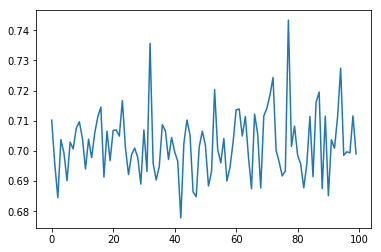

In [40]:
plt.plot(losses.detach())

In [41]:
optimus = optimus.cpu()
optimus.train_net(print_loss=True, lr=0.01, iters=2000,
                 loss_func=torch.nn.BCEWithLogitsLoss())

tensor(0.7420, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7086, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6850, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6683, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6563, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6474, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6406, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6359, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6338, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6336, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6338, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6333, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6316, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6292, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6265, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6242, grad_fn=<BinaryCrossEntropyWithLogitsBac

tensor(0.1859, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1857, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1858, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1864, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1875, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1895, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1909, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1899, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1852, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1826, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1845, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1865, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1849, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1818, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1820, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1838, grad_fn=<BinaryCrossEntropyWithLogitsBac

tensor(0.1586, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1590, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1592, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1587, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1582, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1584, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1588, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1585, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1580, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1580, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1583, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1583, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1579, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1577, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1579, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1579, grad_fn=<BinaryCrossEntropyWithLogitsBac

tensor(0.1571, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1558, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1561, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1559, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1556, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1555, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1556, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1548, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1556, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1548, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1551, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1549, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1546, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1549, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1545, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1547, grad_fn=<BinaryCrossEntropyWithLogitsBac

tensor(0.1529, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1529, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1528, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1528, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1528, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1528, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1528, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1528, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1528, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1528, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1528, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1528, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1528, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1528, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1528, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1527, grad_fn=<BinaryCrossEntropyWithLogitsBac

tensor(0.1517, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1517, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1517, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1517, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1517, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1517, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1518, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1519, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1522, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1528, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1540, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1564, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1620, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1715, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1916, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.2110, grad_fn=<BinaryCrossEntropyWithLogitsBac

tensor(0.1507, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1507, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1507, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1507, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1507, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1506, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1506, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1506, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1506, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1506, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1506, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1506, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1506, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1506, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1506, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1506, grad_fn=<BinaryCrossEntropyWithLogitsBac

tensor(0.1517, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1518, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1500, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1503, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1513, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1506, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1498, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1504, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1508, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1499, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1498, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1505, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1502, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1497, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1498, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1501, grad_fn=<BinaryCrossEntropyWithLogitsBac

tensor(0.1560, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1848, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1670, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1542, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1723, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1576, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1569, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1637, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1539, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1595, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1588, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1557, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1574, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1581, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1525, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1565, grad_fn=<BinaryCrossEntropyWithLogitsBac

tensor(0.1484, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1484, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1484, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1484, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1483, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1483, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1483, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1483, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1483, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1483, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1483, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1483, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1483, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1483, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1483, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1483, grad_fn=<BinaryCrossEntropyWithLogitsBac

tensor(0.1497, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1488, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1478, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1483, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1490, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1485, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1477, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1480, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1486, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1483, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1477, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1478, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1481, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1481, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1477, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1477, grad_fn=<BinaryCrossEntropyWithLogitsBac

tensor(0.1484, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1472, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1481, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1483, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1472, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1474, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1479, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1475, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1471, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1474, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1476, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1471, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1471, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1474, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1472, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1470, grad_fn=<BinaryCrossEntropyWithLogitsBac

tensor(0.1466, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1462, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1460, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1462, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1464, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1463, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1460, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1459, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1461, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1462, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1461, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1459, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1459, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1460, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1461, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.1460, grad_fn=<BinaryCrossEntropyWithLogitsBac

In [42]:
idx = losses.argsort()
losses = losses[idx]

In [43]:
idx

tensor([42,  2, 47, 90, 46, 65, 88, 68, 82, 51, 29, 57,  5, 34, 17, 85, 75, 25,
        52, 31, 76, 11, 58, 35, 81, 83,  1, 33, 55, 74, 41, 19, 38, 13, 28, 64,
        95, 80, 26, 99,  4, 97, 96, 40, 73, 54,  7, 92, 27, 24, 48, 78, 50, 43,
        59,  6, 91,  3, 12, 10, 56, 39, 22, 62, 45, 67, 14, 49, 18, 37, 20, 30,
        21,  8, 79, 36,  9,  0, 44, 15, 93, 84, 63, 89, 69, 98, 66, 60, 61, 70,
        16, 86, 23, 71, 87, 53, 72, 94, 32, 77])

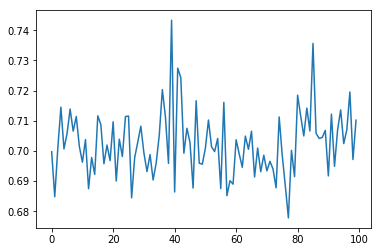

In [44]:
plt.plot(losses[idx].detach())

In [45]:
hessians = hessians[idx, :, :]

In [46]:
e_vals = torch.zeros(n_trial, n_keep)
for tt in range(n_trial):
    e_val, _ = np.linalg.eig(hessians[tt, :, :].cpu())
    idx = np.abs(e_val).argsort()[::-1]   
    e_val = torch.FloatTensor(e_val[idx].real)
    e_vals[tt, :] = e_val

In [ ]:
x_plt = torch.zeros_like(e_vals)
for tt in range(n_trial):
    x_plt[tt, :] = tt

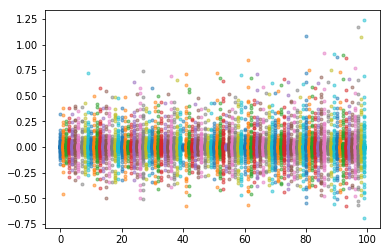

In [ ]:
for tt in range(n_trial):
    plt.plot(x_plt[tt, :], e_vals[tt, :],
            marker='.', alpha=0.5, linestyle='None')

In [ ]:
mean_eval = torch.mean(e_vals, 1)

In [ ]:
mean_eval.shape

torch.Size([100])

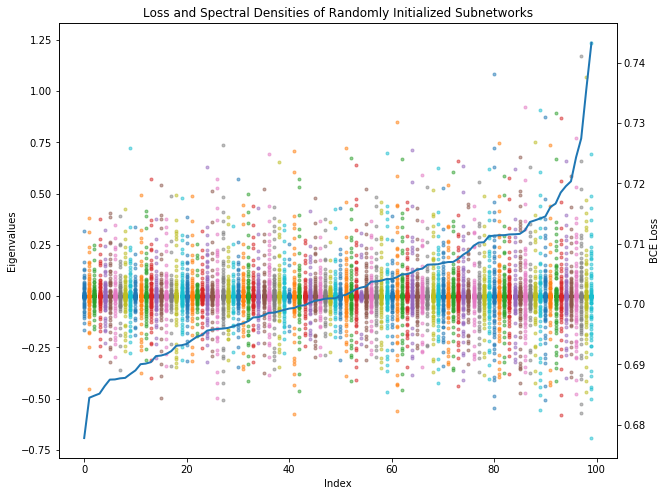

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,8))
for tt in range(n_trial):
    ax1.plot(x_plt[tt, :], e_vals[tt, :],
            marker=".", alpha=0.5, linestyle='None')
ax1.set_ylabel("Eigenvalues")


ax2 = ax1.twinx()
ax2.plot(x_plt[:, 0], losses.detach(),
        linewidth=2.)
ax2.set_ylabel("BCE Loss")
ax1.set_xlabel("Index")
plt.title("Loss and Spectral Densities of Randomly Initialized Subnetworks");

In [ ]:
outputs = optimus(train_x.cpu())
outputs = torch.zeros_like(outputs)
ll = loss_func(outputs, train_y.cpu())

In [ ]:
ll